In [1]:
import PIL
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.functional import F


import torchvision
from torchvision.ops import nms
from torchvision.ops import RoIPool

from torchvision.ops import boxes as box_ops

import pandas as pd
import os
from tqdm.notebook import trange, tqdm
import cv2

import xml.etree.ElementTree as ET
from model import CenterNet

import matplotlib.pyplot as plt

In [2]:
use_cuda = True
device = torch.device('cuda:4' if use_cuda else 'cpu')
x = torch.Tensor([0]).cuda(device)

In [3]:
def drawbbox(img, pre, keep = None, color = '#FF4565'):
    img1 = img.copy()
    ImageD = ImageDraw.Draw(img1)
    for i in range(len(pre['bboxes'])):
        if keep is not None and i not in keep:
            continue
        box = pre['bboxes'][i]
        ImageD.rectangle([(box[0],box[1]),box[2],box[3]],outline= color,width = 2)
        cls_dict = { 'A220':0,
             'A330':1, 
             'A320/321':2, 
             'Boeing737-800':3,
             'Boeing787':4,
             'ARJ21':5, 
             'other':6}
        
        index_dict = {j:i for i,j in cls_dict.items()}
        text = ''
        try:
            label = pre['classes'][i]
            text = text + index_dict[int(label)]
        except:
            pass
        try:
            score = pre['scores'][i]
            text = text + ':' + str(float(score))[:5]
        except:
            pass
        c = (int(box[0]),int(box[1])-12)
        font = ImageFont.truetype('../consolab.ttf',size = 11)
        b = ImageD.textbbox(c,text,font)

        ImageD.rectangle([(b[0],b[1]),b[2]+2,b[3]],fill = color,outline= color)
        ImageD.text(c,text,fill = (255,255,255),font = font,stroke_width=0)
    return img1

In [4]:
def parsexml(gt_path, filename):
    gt_filename = gt_path + filename
    gt_sample = ET.parse(gt_filename)

    img_filename = gt_sample.find('source').find('filename').text

    Objects = gt_sample.find('objects').findall('object')
    objects_name = []
    bboxes = []
    for object in Objects:
        object_name = object.find('possibleresult').find('name').text
        objects_name.append(object_name)
        points = object.find('points').findall('point')
        xmin,ymin = points[0].text.split(',')
        xmax,ymax = points[2].text.split(',')
        bbox = [int(float(xmin)), int(float(ymin)), int(float(xmax)), int(float(ymax))]
        bboxes.append(torch.Tensor(bbox))
    cls_dict = { 'A220':0,
                 'A330':1, 
                 'A320/321':2, 
                 'Boeing737-800':3,
                 'Boeing787':4,
                 'ARJ21':5, 
                 'other':6}
    target = {
                'filename':img_filename,
                'labels':[cls_dict[i] for i in objects_name],
                'boxes':bboxes
            }
    return target

In [5]:
path = '../data/SAR_Airplane_Recognition_trainData/trainData/'
image_path = path + 'Images/'
gt_path = path + 'gt/'

In [6]:
class SAR_dset(torch.utils.data.Dataset):
    def __init__(self, path = '../data/SAR_Airplane_Recognition_trainData/trainData/'):
        super(SAR_dset, self).__init__()
        self.image_path = path + 'Images/'
        self.gt_path = path + 'gt/'
        self.gt_dir = sorted([i for i in os.listdir(self.gt_path) if i[-3:] == 'xml'])
        self.targets = []
        for filename in  self.gt_dir:
            self.targets.append(self.parsexml(gt_path,filename))
        
        self.imgs = []
        for target in tqdm(self.targets, desc = 'Load data'):
            filename = target['filename']
            img = cv2.imread(self.image_path + filename)
            img = torch.from_numpy(img).permute(2,0,1)/255
            self.imgs.append(img)
        
        self.train_img = self.imgs[:1500]
        self.train_targets = self.targets[:1500]
        
        self.test_img = self.imgs[1500:]
        self.test_targets = self.targets[1500:]
        self.mode = 'train'
        
        self.train600 = []
        self.train600_targets = []
        self.train1024 = []
        self.train1024_targets = []
        self.train2048 = []
        self.train2048_targets = []
        
        for i in range(len(self.train_img)):
            if self.train_img[i].shape[-1] == 600:
                self.train600.append(self.train_img[i])
                self.train600_targets.append(self.train_targets[i])
            elif self.train_img[i].shape[-1] == 1024:
                self.train1024.append(self.train_img[i])
                self.train1024_targets.append(self.train_targets[i])
            elif self.train_img[i].shape[-1] == 2048:
                self.train2048.append(self.train_img[i])
                self.train2048_targets.append(self.train_targets[i])
        
        
    def __getitem__(self, index):
        if self.mode == 'train':
            return self.train_img[index],self.train_targets[index]
        elif self.mode == '600':
            return self.train600[index],self.train600_targets[index]
        elif self.mode == '1024':
            return self.train1024[index],self.train1024_targets[index]
        elif self.mode == '2048':
            return self.train2048[index],self.train2048_targets[index]
        else:
            return self.test_img[index],self.test_targets[index]
    
    def __len__(self):
        if self.mode == 'train':
            return len(self.train_img)
        elif self.mode == '600':
            return len(self.train600)
        elif self.mode == '1024':
            return len(self.train1024)
        elif self.mode == '2048':
            return len(self.train2048)
        else:
            return len(self.test_img)
    

        
    def parsexml(self, gt_path, filename):
        gt_filename = gt_path + filename
        gt_sample = ET.parse(gt_filename)

        img_filename = gt_sample.find('source').find('filename').text

        Objects = gt_sample.find('objects').findall('object')
        objects_name = []
        bboxes = []
        for object in Objects:
            object_name = object.find('possibleresult').find('name').text
            objects_name.append(object_name)
            points = object.find('points').findall('point')
            xmin,ymin = points[0].text.split(',')
            xmax,ymax = points[2].text.split(',')
            bbox = [int(float(xmin)), int(float(ymin)), int(float(xmax)), int(float(ymax))]
            bboxes.append(torch.Tensor(bbox))
        cls_dict = { 'A220':0,
                     'A330':1, 
                     'A320/321':2, 
                     'Boeing737-800':3,
                     'Boeing787':4,
                     'ARJ21':5, 
                     'other':6}
        target = {
                    'filename':img_filename,
                    'classes':[cls_dict[i] for i in objects_name],
                    'bboxes':bboxes
                }
        return target

In [7]:
sar_dset = SAR_dset()

Load data:   0%|          | 0/2000 [00:00<?, ?it/s]

In [8]:
# def collect(batch):
# #     print(batch)
#     img,target = [item for item in zip(*batch)]
#     for i in range(len(target)):
#         if isinstance(target[i]['bboxes'],list):
#             target[i]['bboxes'] = torch.stack(target[i]['bboxes'],dim = 0)
#             target[i]['classes'] = torch.from_numpy(np.array(target[i]['classes'],dtype = np.int64))
#     return img,target

In [9]:
def collect(batch):
#     img = torch.unsqueeze(batch[0][0],0)
    img,target = [item for item in zip(*batch)]
    for i in range(len(target)):
        if isinstance(target[i]['bboxes'],list):
            target[i]['bboxes'] = torch.stack(target[i]['bboxes'],dim = 0)
            target[i]['classes'] = torch.from_numpy(np.array(target[i]['classes'],dtype = np.int64))
    return torch.stack(img,0), target

In [10]:
sar_dset.mode = '600'
sar_dataloader600 = torch.utils.data.DataLoader(sar_dset, batch_size = 1, shuffle = True,collate_fn = collect)
sar_dset.mode = '1024'
sar_dataloader1024 = torch.utils.data.DataLoader(sar_dset, batch_size = 1, shuffle = True,collate_fn = collect)
sar_dset.mode = '2048'
sar_dataloader2048 = torch.utils.data.DataLoader(sar_dset, batch_size = 1, shuffle = True,collate_fn = collect)

In [11]:
for x,y in tqdm(sar_dataloader2048):
    pass

  0%|          | 0/260 [00:00<?, ?it/s]

In [12]:
def getTarget(y, device):
    for i in range(len(y)):
        y[i]['bboxes'] = y[i]['bboxes'].cuda(device)
        y[i]['classes'] = y[i]['classes'].cuda(device)
    return y

In [13]:
try:
    centerNet = torch.load('model/centerNet_sar_final.pt')
except:
    centerNet = CenterNet(7)
centerNet.to(device)
centerNet.mode = 'train'

In [14]:
# optimizer = optim.AdamW(centerNet.parameters(), 5e-4)

In [15]:
# centerNet.train()
# centerNet.mode = 'train'
# min_loss = 1e9
# epoch_range = trange(350)
# for epoch in epoch_range:
#     all_loss = 0
#     for i in [600,1024,2048]:
#         if i == 600:
#             myiter = tqdm(sar_dataloader600,colour = '#0066FF')
#             myiter.set_description_str('car dataloader')
#         elif i == 1024:
#             myiter = tqdm(sar_dataloader1024,colour = '#0066FF')
#             myiter.set_description_str('car dataloader')
#         else:
#             myiter = tqdm(sar_dataloader2048,colour = '#0066FF')
#             myiter.set_description_str('car dataloader')
#         for x,y in myiter:
#             x = x.cuda(device)
#             target = getTarget(y,device)
#             result, losses = centerNet(x,y)
#             optimizer.zero_grad()
#             loss = losses['point_focal_loss'] + losses['size_loss'] + losses['offset_loss']
#             loss.backward()
#             optimizer.step()
#             all_loss += float(loss)
#             myiter.set_postfix(epoch = epoch,loss = float(loss),focal_loss = float(losses['point_focal_loss']),
#                                size_loss = float(losses['size_loss']),
#                                offset_loss = float(losses['offset_loss']),all_loss = all_loss)
#     epoch_range.set_postfix(allLoss = float(all_loss),minLoss = float(min_loss))
    
#     if all_loss < min_loss:
#         min_loss = all_loss
#         torch.save(centerNet, 'model/centerNet_sar.pt')

In [41]:
x,y = iter(sar_dataloader600).next()
target = getTarget(y,device)

In [42]:
x = x.cuda(device)

In [43]:
centerNet.eval()
centerNet.mode = 'test'

In [44]:
centerNet.mode = 'train'
result,losses = centerNet(x,target)

In [45]:
result[0]['scores'][result[0]['scores'] > 0.2]

tensor([0.9336, 0.4342, 0.3486, 0.5024, 0.7357, 0.5934, 0.3618, 0.2336, 0.2302,
        0.2287, 0.3628, 0.5422, 0.7874], device='cuda:4')

In [46]:
img = PIL.Image.fromarray((x[0].cpu().permute(1,2,0).numpy()*255).astype(np.uint8))

In [47]:
t = target[0]
t['scores'] = np.zeros(len(t['classes'])) + 1

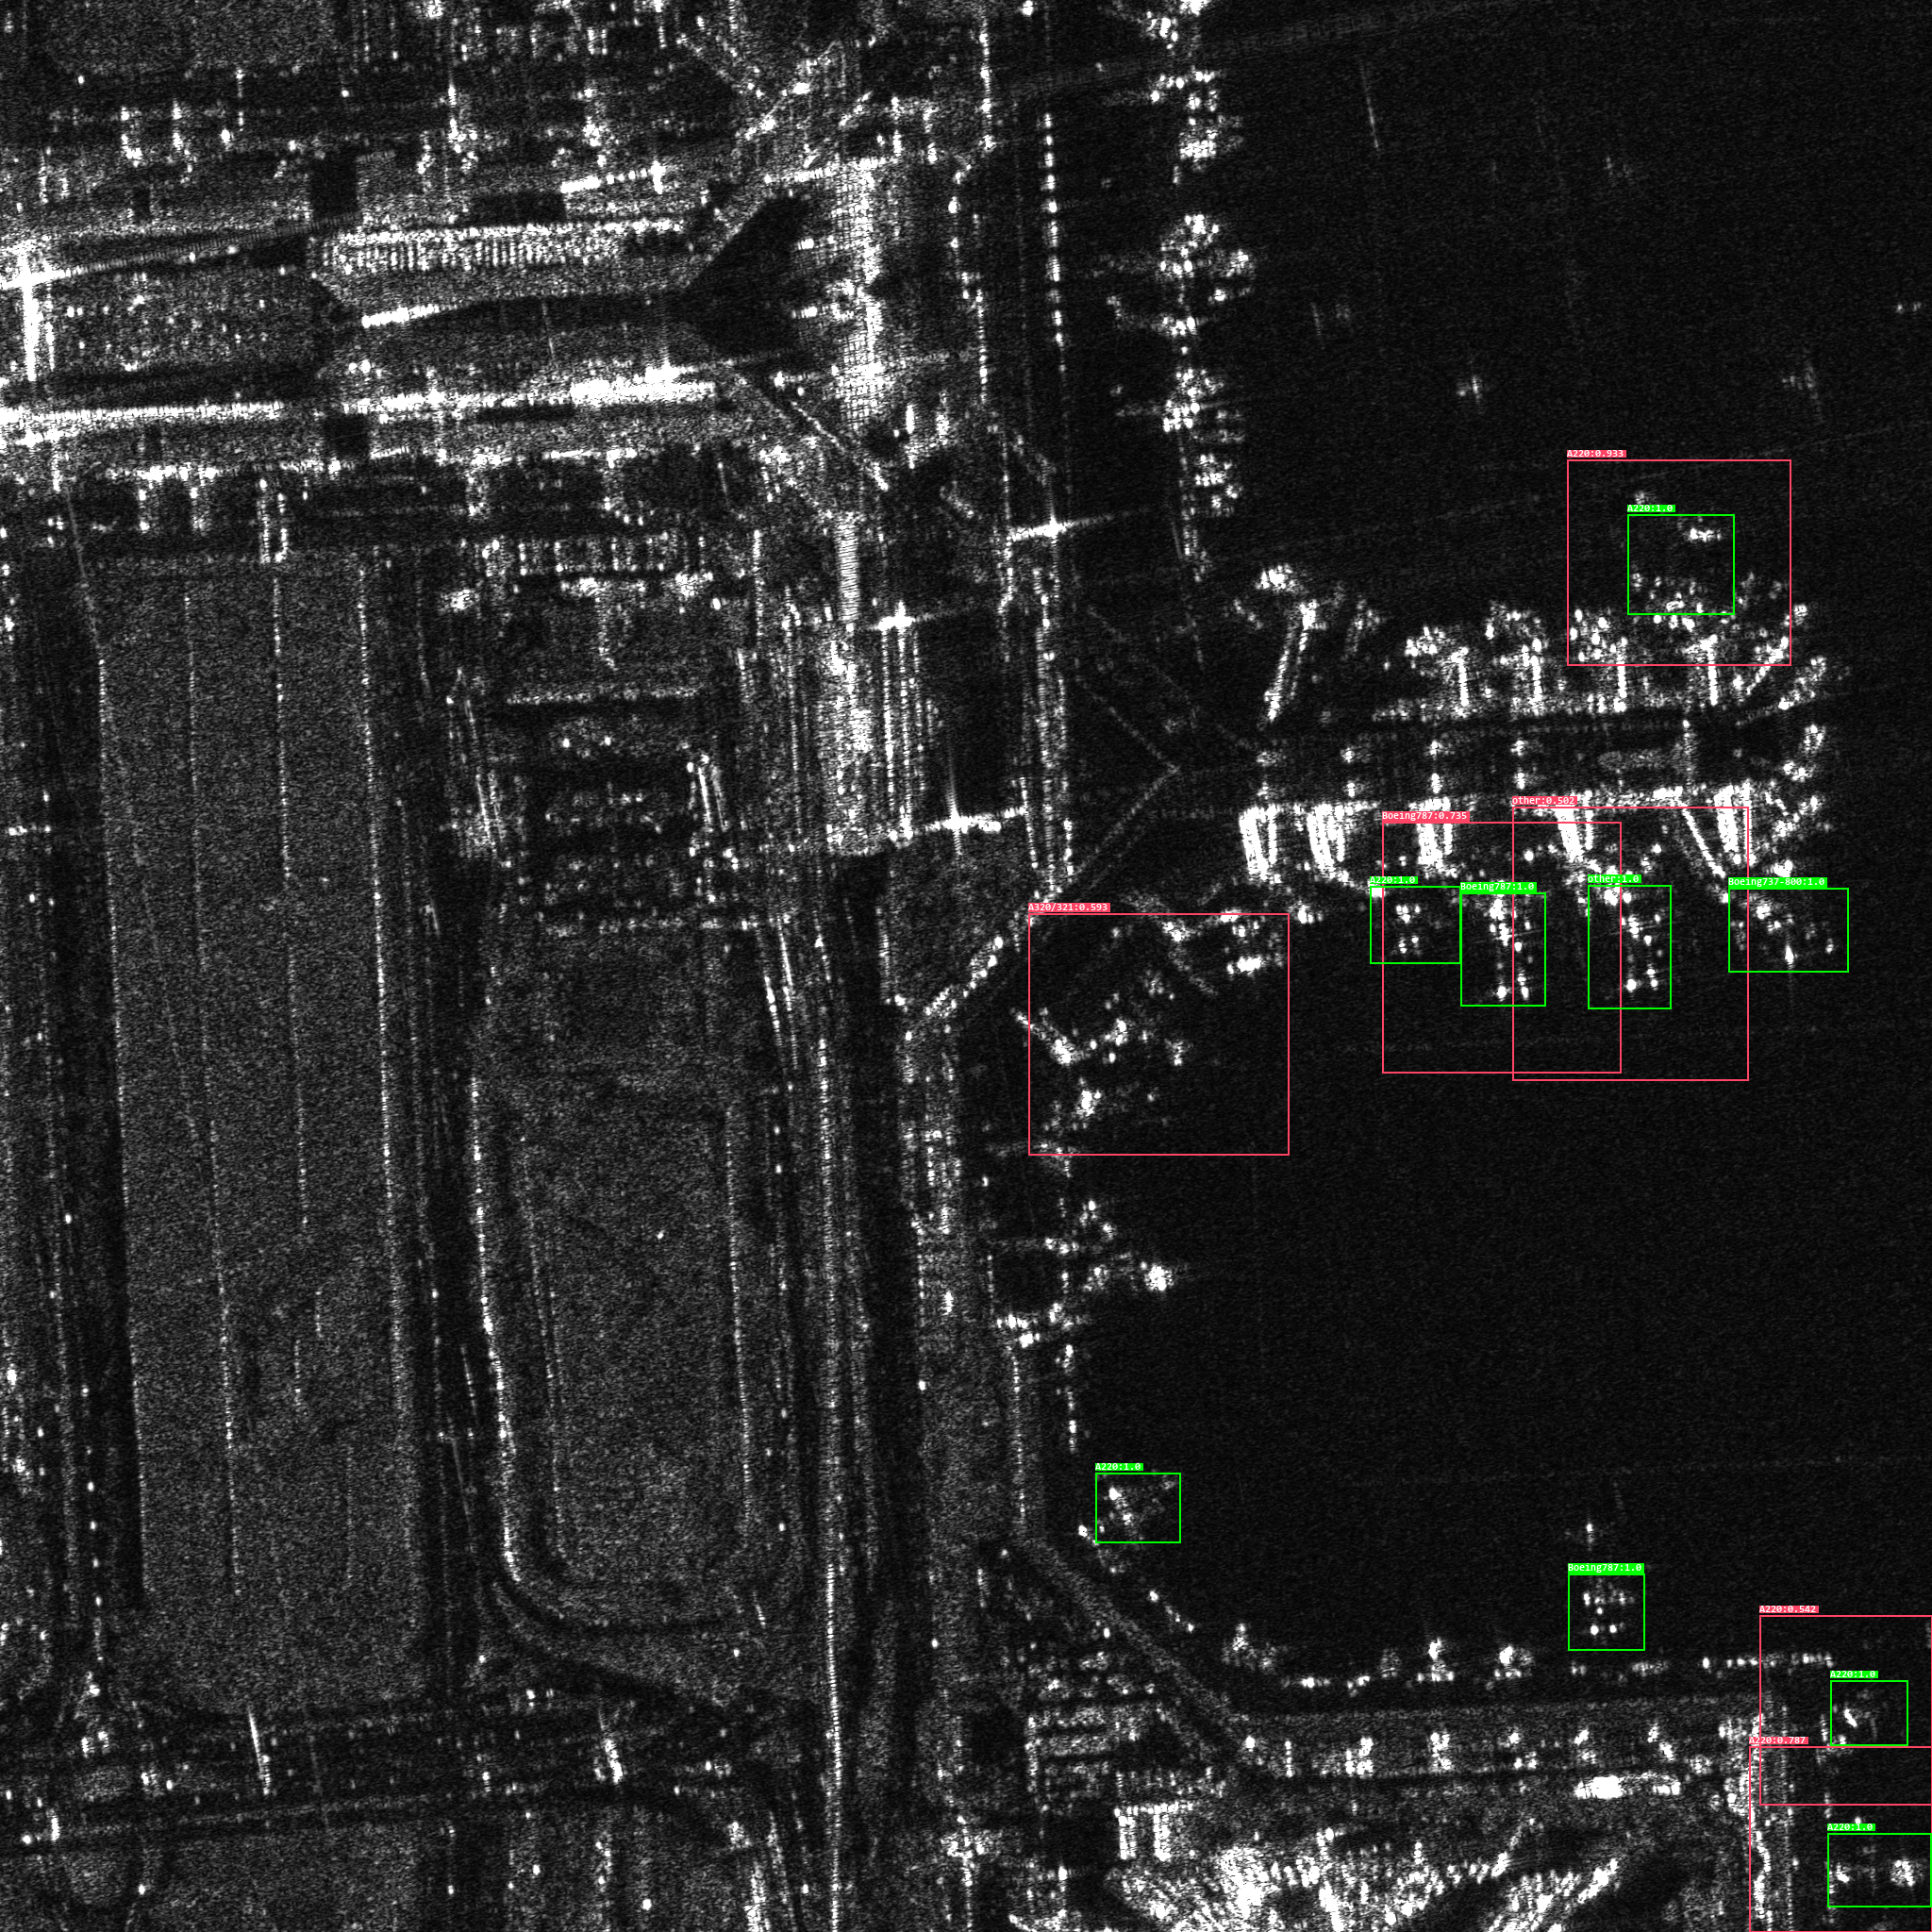

In [48]:
keep = np.where(result[0]['scores'].cpu()>0.5)[0]
img1 = drawbbox(img,result[0],keep)
drawbbox(img1,t,color = '#00FF00')